In [1]:
import os
import pandas as pd
import janitor

dfs = {}

ruta = os.path.join('..', 'data')

years = range(2019, 2024)

for year in years:
    file_path = os.path.join(ruta, f'{year}clean.csv')  # crea la ruta al archivo
    dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario

df2019 = dfs['df2019']
df2020 = dfs['df2020']
df2021 = dfs['df2021']
df2022 = dfs['df2022']
df2023 = dfs['df2023']

df2019['ano']=2019
df2020['ano']=2020
df2021['ano']=2021
df2022['ano']=2022
df2023['ano']=2023


for name, df in dfs.items():
    dfs[name] = df.clean_names()

/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_28780/1287016637.py:13: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_28780/1287016637.py:13: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_28780/1287016637.py:13: DtypeWarning: Columns (6,7,20,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs[f'df{year}'] = pd.read_csv(file_path)  # lee el archivo CSV y lo almacena en el diccionario
/var/folders/n1/5l3l1c6x5xd7lfxmx1cmr21c0000gn/T/ipykernel_28780/1287016637.py:13: DtypeWarning: Columns (6,20,42,43) have m

In [28]:
# Crear una lista de dataframes
dfs_list = [dfs[name] for name in dfs.keys()]

# Concatenar todos los dataframes
contratos_df = pd.concat(dfs_list, ignore_index=True)


In [29]:
from currency_converter import CurrencyConverter


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'object':
        contratos_df[column] = contratos_df[column].str.upper()


for column in contratos_df.columns:
    if contratos_df[column].dtype == 'string':
        contratos_df[column] = contratos_df[column].str.upper()

c = CurrencyConverter()
currencies=['USD', 'CAD', 'EUR', 'GBP', 'JPY']

# Create a dictionary to store conversion rates
conversion_rates = {}

for m in currencies:
    conversion_rate = c.convert(1, m, 'MXN')
    print(1, m, "=", conversion_rate, 'MXN')
    conversion_rates[m] = conversion_rate

# Apply conversion rates
contratos_df["importe"] = contratos_df["importe_del_contrato"]

for currency, conversion_rate in conversion_rates.items():
    contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , 'importe'] = contratos_df.loc[contratos_df['moneda_del_contrato'] == currency , "importe_del_contrato"] * conversion_rate

print('Done')


1 USD = 17.115130976369297 MXN
1 CAD = 13.018183084854396 MXN
1 EUR = 18.6863 MXN
1 GBP = 21.75912340762477 MXN
1 JPY = 0.11946998273767662 MXN
Done


In [30]:
def correct_swap(df):
    # Define un patrón de RFC válido
    rfc_pattern = r"^[A-ZÑ&]{3,4}[0-9]{2}(0[1-9]|1[0-2])(0[1-9]|1[0-9]|2[0-9]|3[0-1])[A-Z0-9]?[A-Z0-9]?[0-9A]$"

    # Rellena los NaN con una cadena vacía para poder aplicar str.match
    df.fillna("", inplace=True)

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es un RFC válido
    mask_invalid = ~df['rfc'].str.match(rfc_pattern) & df['proveedor_o_contratista'].str.match(rfc_pattern)

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas
    df.loc[mask_invalid, 'rfc'], df.loc[mask_invalid, 'proveedor_o_contratista'] = df.loc[mask_invalid, 'proveedor_o_contratista'], df.loc[mask_invalid, 'rfc']

    # Identifica las filas donde 'rfc' no es un RFC válido y 'proveedor_o_contratista' es una cadena vacía
    mask_invalid_empty = ~df['rfc'].str.match(rfc_pattern) & (df['proveedor_o_contratista'] == "")

    # Intercambia 'rfc' y 'proveedor_o_contratista' para las filas identificadas y asigna un valor artificial a 'rfc'
    df.loc[mask_invalid_empty, 'rfc'], df.loc[mask_invalid_empty, 'proveedor_o_contratista'] = 'XAXX010101000', df.loc[mask_invalid_empty, 'rfc']

    # Reemplaza las cadenas vacías con NaN de nuevo
    df.replace("", np.nan, inplace=True)

    return df

# Supón que contratos_df es tu DataFrame original
contratos_df = correct_swap(contratos_df)


In [32]:
def verify_correction(df):
    # Identificar filas donde rfc tiene una longitud distinta a 13
    mask = df['rfc'].str.len() != 12
    # Retornar filas donde rfc tiene una longitud distinta a 13
    return df.loc[mask]

verify_correction(contratos_df[['rfc', 'proveedor_o_contratista']])

,rfc,proveedor_o_contratista
14895,XAXX010101000,ARBAVEL A.C.
16833,XAXX010101000,JESUS GARCIA
16973,XAXX010101000,DAVID ROMERO
21692,XAXX010101000,CRUZ ROBLEDO
23257,XAXX010101000,PAVLO GETMAN
...,...,...
471121,XAXX010101000,FRANCISCO JAVIER MONROY SANCHEZ
471122,XAXX010101000,ALEXIA ANAEL AVILA SOLIS
471137,XAXX010101000,JOSE DE JESUS DIAZ CORONA
471138,XAXX010101000,TOMAS ESPINOZA BENAVIDES


### Función de búsqueda

In [13]:
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution = input("Por favor, ingresa las siglas de la institución (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()  # Creamos una copia del DataFrame

    filtered_df[['proveedor_o_contratista', 'descripcion_del_contrato']] = filtered_df[['proveedor_o_contratista', 'descripcion_del_contrato']].fillna('')


# Convierte las columnas de texto a minúsculas
    filtered_df['proveedor_o_contratista'] = filtered_df['proveedor_o_contratista'].str.upper()
    filtered_df['siglas_de_la_institucion'] = filtered_df['siglas_de_la_institucion'].str.upper()
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].str.upper()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        if len(search_term) == 12 and search_term.isalnum(): # RFC en México tiene 13 caracteres y sólo contiene letras y números
            filtered_df = filtered_df.loc[filtered_df['rfc'] == search_term]
        else:
            filtered_df = filtered_df.loc[filtered_df['proveedor_o_contratista'].str.contains(search_term, case=False)]

    # Filtra por institución si se proporciona
    if institution != 'todas' and institution:
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'] == institution]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        for keyword in keywords.split(','):
            keyword = keyword.strip()  # Remueve los espacios adicionales al principio y al final de la palabra
            filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keyword, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        for word in exclude_words.split(','):
            word = word.strip()  # Remueve los espacios adicionales al principio y al final de la palabra
            filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(word, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df

# Usa la función:


In [31]:
import pandas as pd
import re

# Función de filtrado
def filter_contratos(contratos_df):
    # Solicita al usuario un proveedor o contratista o RFC
    search_term = input("Por favor, ingresa el nombre del proveedor o contratista o el RFC (déjalo en blanco para mostrar todos): ").upper()

    # Solicita al usuario las siglas de la institución o "todas" para buscar en todas
    institution = input("Por favor, ingresa las siglas de la institución (déjalo en blanco para mostrar todas) o 'todas' para buscar en todas: ").upper()

    # Solicita al usuario las palabras clave en la descripción del contrato
    keywords = input("Por favor, ingresa las palabras clave en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para buscar todas): ").upper()

    # Solicita al usuario las palabras a excluir en la descripción del contrato
    exclude_words = input("Por favor, ingresa las palabras a excluir en la descripción del contrato (separa múltiples palabras con comas, déjalo en blanco para no excluir ninguna): ").upper()

    # Inicialmente asumimos todos los contratos
    filtered_df = contratos_df.copy()  # Creamos una copia del DataFrame

    filtered_df[['proveedor_o_contratista', 'descripcion_del_contrato', 'rfc']] = filtered_df[['proveedor_o_contratista', 'descripcion_del_contrato', 'rfc']].fillna('')

    # Convierte las columnas de texto a mayúsculas
    filtered_df['proveedor_o_contratista'] = filtered_df['proveedor_o_contratista'].str.upper()
    filtered_df['siglas_de_la_institucion'] = filtered_df['siglas_de_la_institucion'].str.upper()
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].str.upper()
    filtered_df['rfc'] = filtered_df['rfc'].str.upper()

    # Filtra por proveedor o contratista o RFC si se proporciona
    if search_term:
        search_terms = [term.strip() for term in search_term.split(',')]
        search_conditions = [filtered_df['proveedor_o_contratista'].str.contains(term, case=False) | filtered_df['rfc'].str.contains(term, case=False) for term in search_terms]
        combined_search_condition = pd.concat(search_conditions, axis=1).any(axis=1)
        filtered_df = filtered_df.loc[combined_search_condition]

    # Filtra por institución si se proporciona
    if institution != 'todas' and institution:
        institution = '|'.join(re.escape(inst.strip()) for inst in institution.split(','))
        filtered_df = filtered_df.loc[filtered_df['siglas_de_la_institucion'].str.contains(institution, case=False)]

    # Reemplaza los NaN en la descripción del contrato por cadenas vacías
    filtered_df['descripcion_del_contrato'] = filtered_df['descripcion_del_contrato'].fillna('')

    # Filtra por palabras clave en la descripción del contrato si se proporcionan
    if keywords:
        keywords = '|'.join(re.escape(keyword.strip()) for keyword in keywords.split(','))
        filtered_df = filtered_df.loc[filtered_df['descripcion_del_contrato'].str.contains(keywords, case=False)]

    # Excluye contratos que contienen ciertas palabras en la descripción del contrato si se proporcionan
    if exclude_words:
        exclude_words = '|'.join(re.escape(word.strip()) for word in exclude_words.split(','))
        filtered_df = filtered_df.loc[~filtered_df['descripcion_del_contrato'].str.contains(exclude_words, case=False)]

    # Ordena el DataFrame filtrado por importe en orden descendente
    filtered_df = filtered_df.sort_values(by='importe', ascending=False)

    # Muestra el DataFrame filtrado
    return filtered_df


# Búsqueda

In [52]:
# Usa la función:
buscar = filter_contratos(contratos_df)
buscar[['tipo_de_procedimiento', 'siglas_de_la_institucion', 'titulo_del_contrato', 'descripcion_del_contrato','rfc','proveedor_o_contratista', 'importe', 'direccion_del_anuncio', 'ano']]

,tipo_de_procedimiento,siglas_de_la_institucion,titulo_del_contrato,descripcion_del_contrato,rfc,proveedor_o_contratista,importe,direccion_del_anuncio,ano
208540,ADJUDICACIÓN DIRECTA,BIRMEX,ADQUISICIÓN DE VINCRISTINA SOLUCIÓN INYECTABLE...,ADQUISICIÓN DE VINCRISTINA SOLUCIÓN INYECTABLE...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"30,066,982.552704707",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
134360,ADJUDICACIÓN DIRECTA,SEMAR,IMP. 13-SCIA/003-2020,ADQUISICIÓN DE MEDICAMENTOS ONCOLOGICOS DE DIF...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"5,389,178.2115772115",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2020
275278,OTRAS CONTRATACIONES,INCAN,MEDICINAS Y PRODUCTOS FARMACÉUTICOS PARA EL IN...,MEDICINAS Y PRODUCTOS FARMACÉUTICOS PARA EL I...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"2,037,960.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
417081,ADJUDICACIÓN DIRECTA,BIRMEX,"ADQUISICIÓN DE AMINOFILINA, SOLUCIÓN INYECTABL...","ADQUISICIÓN DE AMINOFILINA, SOLUCIÓN INYECTABL...",NME940113L8A,NEURONIC MEXICANA SA DE CV,"1,353,642.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
352341,ADJUDICACIÓN DIRECTA,BIRMEX,ADQUISICIÓN DE FLUOROURACILO. SOLUCIÓN INYECTA...,ADQUISICIÓN DE FLUOROURACILO. SOLUCIÓN INYECTA...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"596,700.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2022
287783,ADJUDICACIÓN DIRECTA,INCMNSZ,010.000.6220.02 FLUOROURACILO. SOLUCION INYECT...,010.000.6220.02 FLUOROURACILO. SOLUCION INYECT...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"415,140.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
298865,ADJUDICACIÓN DIRECTA,INSABI,ADQUISICIÓN CONSOLIDADA DE MEDICAMENTOS Y BIEN...,ADQUISICIÓN CONSOLIDADA DE MEDICAMENTOS Y BIEN...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"255,000.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
288716,ADJUDICACIÓN DIRECTA,INCMNSZ,010.000.6220.02 FLUOROURACILO. SOLUCION INYECT...,010.000.6220.02 FLUOROURACILO. SOLUCION INYECT...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"102,000.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021
273439,OTRAS CONTRATACIONES,HRAEI,ADQUSICIÓN DE MEDICAMEMENTOS Y BIENES TERAPÉUT...,ADQUSICIÓN DE MEDICAMEMENTOS Y BIENES TERAPÉUT...,NME940113L8A,NEURONIC MEXICANA SA DE CV,"14,280.0",HTTPS://COMPRANET.HACIENDA.GOB.MX/ESOP/GUEST/G...,2021



### Resultados de búsqueda por institución

In [53]:
pd.options.display.float_format = '{:,}'.format

ins_df=buscar.groupby(['siglas_de_la_institucion', 'institucion', 'proveedor_o_contratista']).agg({'importe':'sum'}).reset_index()

ins_df.sort_values(by='importe', ascending=False, inplace=True)
#institucion.set_index('Institución', inplace=True)

proveedor = ins_df['proveedor_o_contratista'].iloc[0]
ins_df

,siglas_de_la_institucion,institucion,proveedor_o_contratista,importe
0,BIRMEX,LABORATORIOS DE BIOLÓGICOS Y REACTIVOS DE MÉXI...,NEURONIC MEXICANA SA DE CV,"32,017,324.552704707"
5,SEMAR,SECRETARÍA DE MARINA,NEURONIC MEXICANA SA DE CV,"5,389,178.2115772115"
2,INCAN,INSTITUTO NACIONAL DE CANCEROLOGÍA,NEURONIC MEXICANA SA DE CV,"2,037,960.0"
3,INCMNSZ,INSTITUTO NACIONAL DE CIENCIAS MÉDICAS Y NUTRI...,NEURONIC MEXICANA SA DE CV,"517,140.0"
4,INSABI,INSTITUTO DE SALUD PARA EL BIENESTAR,NEURONIC MEXICANA SA DE CV,"255,000.0"
1,HRAEI,HOSPITAL REGIONAL DE ALTA ESPECIALIDAD DE IXTA...,NEURONIC MEXICANA SA DE CV,"14,280.0"


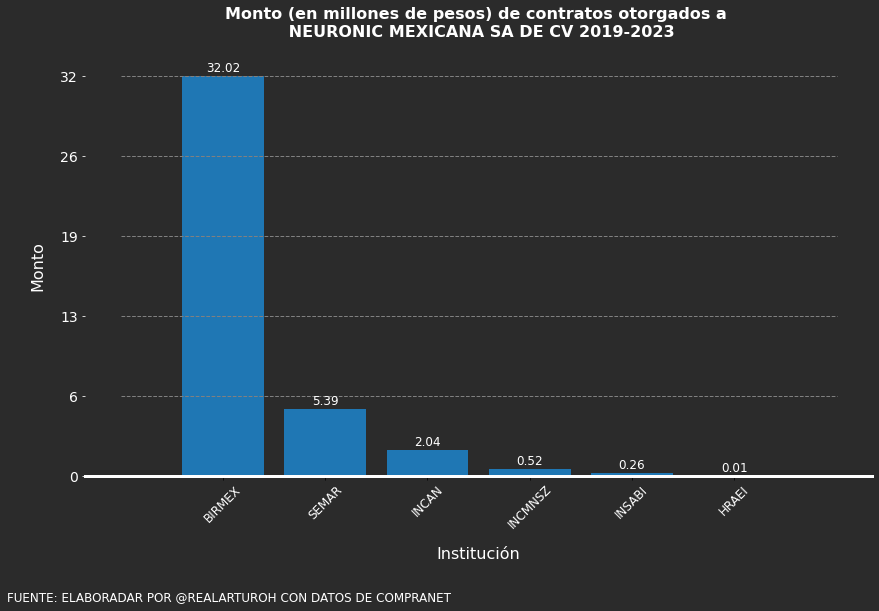

In [54]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# Asigna los valores
instituciones = ins_df['siglas_de_la_institucion'].values
importe = ins_df['importe'].values / 1e6  # Convertimos a millones

# Ajusta el tamaño de la figura de acuerdo al número de instituciones
if len(instituciones) > 10:
    fig, ax = plt.subplots(figsize=(0.5*len(instituciones), 8))
else:
    fig, ax = plt.subplots(figsize=(12, 8))

# Genera las barras
bars = ax.bar(instituciones, importe, color='#1f77b4')

# Asigna los títulos y etiquetas
ax.set_title(f"Monto (en millones de pesos) de contratos otorgados a \n {proveedor} 2019-2023", fontsize=16, pad=20, fontweight='bold', color='white')
ax.set_xlabel("Institución", fontsize=16, labelpad=15, color='white')
ax.set_ylabel("Monto", fontsize=16, labelpad=15, color='white')

# Asigna los localizadores de las etiquetas del eje X y rota las etiquetas
ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(instituciones))))
ax.set_xticklabels(instituciones, fontsize=12, rotation=45, color='white')

# Formatea las etiquetas del eje Y
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='y', labelsize=14, colors='white')

# Establece un intervalo de líneas horizontales basado en los datos
y_interval = max(importe) / 5
ax.yaxis.set_major_locator(ticker.MultipleLocator(y_interval))
for y in np.arange(0, max(importe)+y_interval, y_interval):
    plt.hlines(y, xmin=-1, xmax=len(instituciones), colors='gray', linestyles='dashed', linewidth=1)

# Cambia el color de fondo de la figura y de los ejes
fig.set_facecolor('#2b2b2b')
ax.set_facecolor('#2b2b2b')

# Elimina el cuadro alrededor de la gráfica excepto la línea del eje x
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)

ax.spines['bottom'].set_linewidth(3)  # Ajusta el número para cambiar el grosor
ax.spines['bottom'].set_color('white')

# Añade las etiquetas de las cantidades sobre las barras con un tamaño pequeño y sutil
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval+0.1, round(yval, 2), ha='center', va='bottom', fontsize=12, color='white')

# Agrega la leyenda
plt.figtext(0.5, -0.05, "FUENTE: ELABORADAR POR @REALARTUROH CON DATOS DE COMPRANET", ha="right", fontsize=12, color='white')

# Ajusta el layout para que los títulos no se corten y muestra la gráfica
plt.tight_layout()
plt.show()


### Resultados de búsqueda por proveedor

In [55]:
import pandas as pd

pd.options.display.float_format = '{:,}'.format

prov_df=buscar.groupby(['proveedor_o_contratista', 'rfc']).agg({'importe':'sum'}).reset_index()

prov_df.sort_values(by='importe', ascending=False, inplace=True)

def convert_year(two_digit_year):
    if two_digit_year.isdigit():
        year_int = int(two_digit_year)
        if year_int > 23:
            return "19" + two_digit_year
        else:
            return "20" + two_digit_year
    else:
        return "unknown"  # or some other default value

prov_df['año_constitucion'] = prov_df['rfc'].apply(lambda x: convert_year(str(x)[3:5]) if len(str(x)) >= 5 else "unknown")

#prov_df[prov_df['año_constitucion']>='2019']

prov_df

,proveedor_o_contratista,rfc,importe,año_constitucion
0,NEURONIC MEXICANA SA DE CV,NME940113L8A,"40,230,882.76428192",1994
